In [1]:
import json
import logging
from typing import List, Tuple

import pandas as pd
from rdkit import Chem, RDLogger
from rdkit.Chem import Draw
from rdkit.Chem.rdChemReactions import ReactionFromSmarts

from syndirella.SMARTSHandler import SMARTSHandler
from syndirella.route.Reaction import Reaction

logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# Set the logging level for the PIL library to WARNING to suppress DEBUG logs
pil_logger = logging.getLogger('PIL')
pil_logger.setLevel(logging.WARNING)
# Suppress RDKit errors
RDLogger.DisableLog('rdApp.error')

/Users/kate_fieseler/PycharmProjects/syndirella/syndirella/..


## Goal: Add `amidation` as an additional reaction option to `ester_amidation`

Since we already have `ester_amidation` defined, we just need to work on figuring out how to edit the reactants used in `ester_amidation` to be used in `amidation`.




### Step 1: Determine how to convert reactants for `ester_amidation` to `amidation`.

Amidation
[#6:1](=[#8:2])-[#8;H1].[$([N+0&H1,N+0&H2]);!$(NC=*);!$(NS);!$(N=*);!$(N-O);!$(N-o):3]>>[#6:1](=[#8:2])-[#7X3:3]


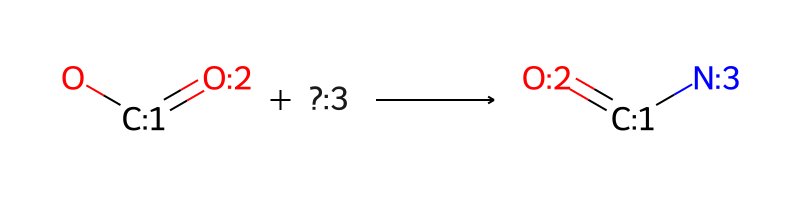

Ester amidation
C-[O;R0]-[C;H0;D3;+0;R0:1](-[#6:2])=[O;D1;H0:3].[N;H1,H2;+0:5]>>[N&X3;+0:5]-[C;H0;D3;+0:1](-[#6:2])=[O;D1;H0:3]


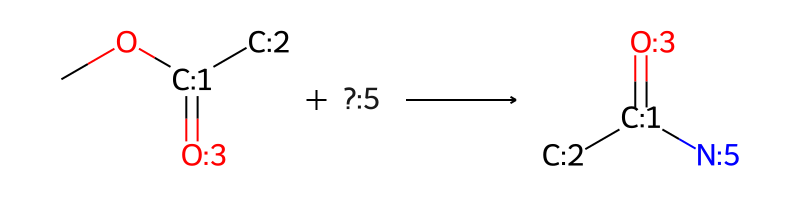

In [2]:
# Let's view amidation
with open('../../../syndirella/constants/RXN_SMIRKS_CONSTANTS.json', 'r') as f:
    rxn_smirks = json.load(f)
amidation_smirks = rxn_smirks['Amidation']
amidation = ReactionFromSmarts(amidation_smirks)
print('Amidation')
print(amidation_smirks)
img = Draw.ReactionToImage(amidation)
display(img)

ester_amidation_smirks = rxn_smirks['Ester_amidation']
ester_amidation = ReactionFromSmarts(ester_amidation_smirks)
print('Ester amidation')
print(ester_amidation_smirks)
img = Draw.ReactionToImage(ester_amidation)
display(img)

> I would recommend to view this reaction using [https://smarts.plus/](https://smarts.plus/) to understand the exact specification of the reaction.

By eye, the amine reactant in both reactions can remain the same. All we need to change is converting the ether oxygen in the ester amidation reaction to a hydroxyl group.



### Step 2: Define how to replace reactants in the `ester_amidation`.

Follow the structure of `ADDITIONAL_RXN_OPTIONS.json` to define the new reaction option with replacing the ether oxygen in the ester amidation reaction to a hydroxyl group.

Reactant atoms to replace:


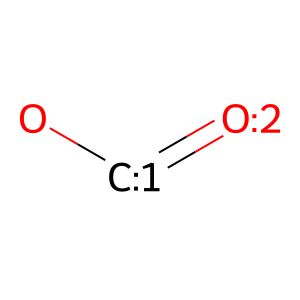

New reactant atoms to add:


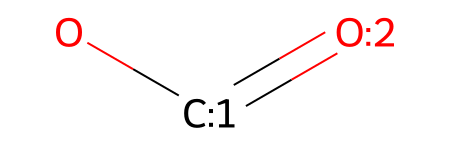

In [3]:
new_config = [{
    'name': 'Ester_amidation',
    'replace_with': 'Amidation',
    'reactant_smarts_to_replace': "[C;H0;D3;+0;R0:1](=[O;D1;H0:2])-[O;R0X2]",
    'reactant_id_to_replace': 1,
    'reactant_smarts_to_replace_with': "[#6:1](=[#8:2])-[#8;H1]",
    'replacement_connecting_atom_id': 0  # central carbon atom
}]

# can also view at [https://smarts.plus/smartsview](https://smarts.plus/smartsview)
img = Draw.MolToImage(Chem.MolFromSmarts(new_config[0]['reactant_smarts_to_replace']))
print("Reactant atoms to replace:")
display(img)
print("New reactant atoms to add:")
Chem.MolFromSmarts(new_config[0]['reactant_smarts_to_replace_with'])

> **Important**: The order you write the atoms in the SMARTS string is important, make sure the atoms for both SMARTS strings are written in as similar order as possible.

### Step 2: Test additional reaction on examples.

In [4]:
df = pd.read_csv('../fairydust_example_data/ester_amidation_examples.csv')
df

smiles         1_r1_smiles   
0                      Cn1nccc1C(=O)NCc1ccc(O)s1        NCc1ccc(O)s1  \
1                 O=C(NCc1cccs1)c1c(O)ccc2c1OCO2           NCc1cccs1   
2  NC(=O)Nc1cccc(NC(=O)CCc2nc(Cn3ccccc3=O)no2)c1  NC(=O)Nc1cccc(N)c1   

                     1_r2_smiles       1_reaction  
0               CCOC(=O)c1ccnn1C  Ester_amidation  
1       CCOC(=O)c1c(O)ccc2c1OCO2  Ester_amidation  
2  COC(=O)CCc1nc(Cn2ccccc2=O)no1  Ester_amidation

Ester amidation examples


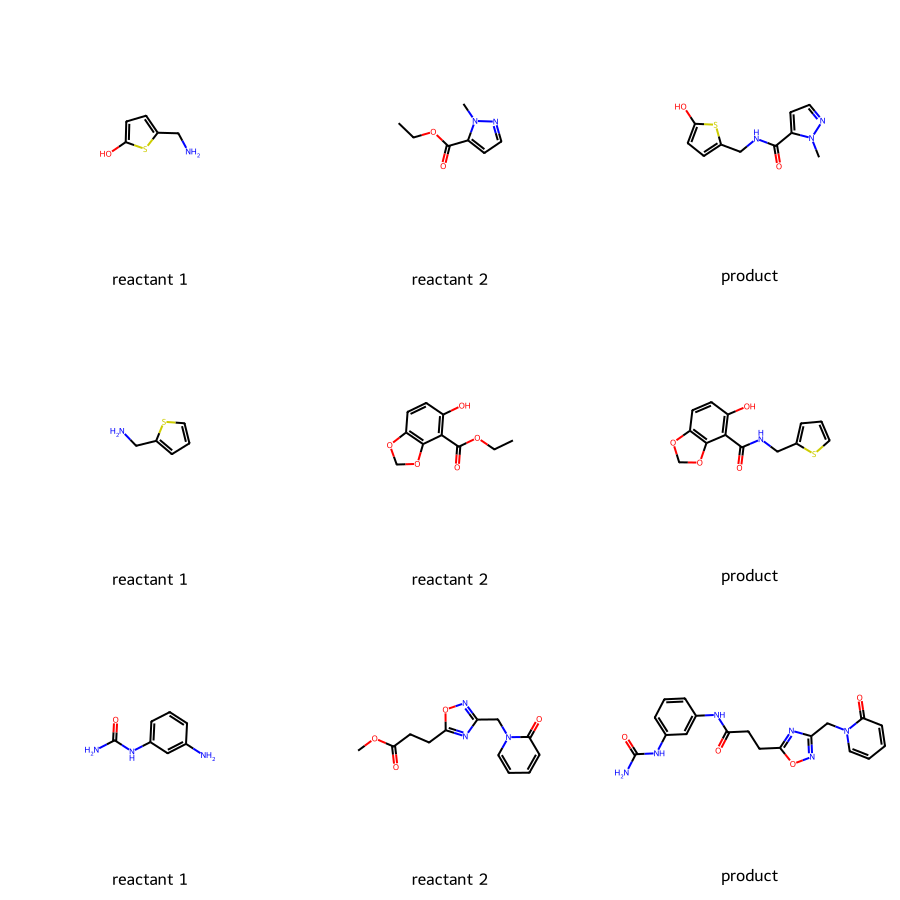

In [5]:
# display the reaction
mols = []
legend = []
for i, row in df.iterrows():
    mols.append(Chem.MolFromSmiles(row['1_r1_smiles']))
    mols.append(Chem.MolFromSmiles(row['1_r2_smiles']))
    mols.append(Chem.MolFromSmiles(row['smiles']))
    legend.extend(['reactant 1', 'reactant 2', 'product'])
print('Ester amidation examples')
Draw.MolsToGridImage(mols, legends=legend, molsPerRow=3, subImgSize=(300, 300))

In [6]:
# Testing
reaction_name: str = 'Ester_amidation'
smarts_handler: SMARTSHandler = SMARTSHandler()
route_uuid: str = '1235'
logger = logging.getLogger('Test')
smirks = rxn_smirks['Amidation']

for i in range(0, len(df)):
    product: Chem.Mol = Chem.MolFromSmiles(df['smiles'][i])
    reactants: List[Chem.Mol] = [Chem.MolFromSmiles(df['1_r1_smiles'][i]), Chem.MolFromSmiles(df['1_r2_smiles'][i])]
    rxn = Reaction(product=product, reactants=reactants, reaction_name=reaction_name, smarts_handler=smarts_handler,
                   route_uuid=route_uuid)
    rxn.logger = logger
    rxn.alt_reactions = new_config
    new_reaction: List[Tuple[str, Tuple[
        str, str]]] = rxn.get_additional_reactions()  # returns a list of tuples with the reaction name and reactants

    r1 = Chem.MolFromSmiles(new_reaction[0][1][0])
    r2 = Chem.MolFromSmiles(new_reaction[0][1][1])
    reaction: Chem.rdChemReactions = ReactionFromSmarts(smirks)
    new_reactant_combo: Tuple[Chem.Mol] = (r1, r2)
    products: Tuple[Chem.Mol] = reaction.RunReactants(new_reactant_combo)
    pred_prod = products[0][0]
    expected_inchi = Chem.MolToInchiKey(product)
    pred_inchi = Chem.MolToInchiKey(pred_prod)
    print(f'Expected Inchi: {expected_inchi}')
    print(f'Predicted Inchi: {pred_inchi}')
    print(f'Inchi Match: {expected_inchi == pred_inchi}')

2025-02-11 13:27:35,911 - Test - INFO - Additional reaction Amidation found for Ester_amidation.
2025-02-11 13:27:35,912 - Test - INFO - to_replace_with_smarts: [#6:1](=[#8:2])-[#8;H1]
2025-02-11 13:27:35,912 - Test - INFO - Found 1 new reactants.
2025-02-11 13:27:35,912 - Test - INFO - Checking new reactant CC.Cn1nccc1[C:1](O)=[O:2] for reaction Ester_amidation...
2025-02-11 13:27:35,913 - Test - DEBUG - Multiple fragmented molecules found in new reactant.
2025-02-11 13:27:35,913 - Test - DEBUG - Replaced reactant smiles: Cn1nccc1[C:1](O)=[O:2]
2025-02-11 13:27:35,913 - Test - DEBUG - Matched atoms: (6, 8, 7)
2025-02-11 13:27:35,913 - Test - INFO - New reactant for reaction Ester_amidation found.
2025-02-11 13:27:35,913 - Test - INFO - Additional reaction Amidation for Ester_amidation found and validated.
2025-02-11 13:27:35,916 - Test - INFO - Additional reaction Amidation found for Ester_amidation.
2025-02-11 13:27:35,916 - Test - INFO - to_replace_with_smarts: [#6:1](=[#8:2])-[#8;H

Expected Inchi: IMTCTUMLWQUKFC-UHFFFAOYSA-N
Predicted Inchi: IMTCTUMLWQUKFC-UHFFFAOYSA-N
Inchi Match: True
Expected Inchi: LSBSLADJXDRYPT-UHFFFAOYSA-N
Predicted Inchi: LSBSLADJXDRYPT-UHFFFAOYSA-N
Inchi Match: True
Expected Inchi: TYBDSUPMDPIPBB-UHFFFAOYSA-N
Predicted Inchi: TYBDSUPMDPIPBB-UHFFFAOYSA-N
Inchi Match: True


In [7]:
new_reaction

[('Amidation', ('O=c1ccccn1Cc1noc(CC[C:1](O)=[O:2])n1', 'NC(=O)Nc1cccc(N)c1'))]

Nice it worked! Lets add to the `ADDITIONAL_RXN_OPTIONS.json` file.

In [8]:
# write new ADDITIONAL_RXN_OPTIONS.json
path = '../../../syndirella/constants/ADDITIONAL_RXN_OPTIONS.json'
with open(path, 'r') as file:
    additional_rxn_options = json.load(file)
# check if entry already exists
entry_exists = False
for entry in additional_rxn_options:
    # check if all values are the same
    if all([entry[key] == new_config[0][key] for key in new_config[0].keys()]):
        entry_exists = True
        print(f"Entry with name {new_config[0]['name']} and all same values already exists.")
        break

# add new entry if it doesn't exist
if not entry_exists:
    additional_rxn_options.extend(new_config)
    print(f"Added new entry with name {new_config[0]['name']} to ADDITIONAL_RXN_OPTIONS.json")
    # save
    with open(path, 'w') as file:
        json.dump(additional_rxn_options, file, indent=4)

Entry with name Ester_amidation and all same values already exists.
